# Описание проекта. Телеком

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов.

Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

В ходе данного проекта необходимо будет произвести предобработку и исследовательский анализ данных, а так же обучить и протестировать три модели: случайный лес, градиентный бустинг и полносвязную нейросеть прямого распостранения. Наша основная метрика в данном проекте - ROC-AUC, и ее целевое значение >= 0.85

## 1. Импорт библиотек и загрузка данных.

In [1]:
import warnings
import time
import shap
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from phik import phik_matrix
from scipy.stats import boxcox
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from optuna.samplers import RandomSampler
import lightgbm as lgb
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)
pd.set_option('display.max_columns', None)

path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

RANDOM_STATE = 2112025

In [3]:
query = ''' 
       SELECT * 
FROM contract 

'''       
df = pd.read_sql_query(query, con = engine)

query = ''' 
       SELECT * 
FROM personal 

'''       
customers = pd.read_sql_query(query, con = engine)


query = ''' 
       SELECT * 
FROM internet

'''       
internet_users = pd.read_sql_query(query, con = engine)

query = ''' 
       SELECT * 
FROM phone

'''       
phone_users = pd.read_sql_query(query, con = engine)

In [55]:
for i,z in zip([df,customers,internet_users,phone_users],['df','customers','internet_users','phone_users']):
    print(z)
    print()
    display(i.info())
    display(i.head())
    print(f'ПРОПУСКОВ В {z}: {i.isna().sum().sum()}')
    print(f'ЯВНЫХ ДУБЛИКАТОВ В {z}: {i.duplicated().sum()}')
    print('-------------------------------------------------------------------------------------------------------------')
    print()

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Target            7043 non-null   int64  
 7   Duration          7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


None

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


ПРОПУСКОВ В df: 0
ЯВНЫХ ДУБЛИКАТОВ В df: 0
-------------------------------------------------------------------------------------------------------------

customers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


ПРОПУСКОВ В customers: 0
ЯВНЫХ ДУБЛИКАТОВ В customers: 0
-------------------------------------------------------------------------------------------------------------

internet_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


ПРОПУСКОВ В internet_users: 0
ЯВНЫХ ДУБЛИКАТОВ В internet_users: 0
-------------------------------------------------------------------------------------------------------------

phone_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


ПРОПУСКОВ В phone_users: 0
ЯВНЫХ ДУБЛИКАТОВ В phone_users: 0
-------------------------------------------------------------------------------------------------------------



Для дальнейшего корректного объединения таблиц необходимо единообразие между названиями колонок с идентификаторами пользователей. Таблица 'phone_users' выбивается из этого единообразия. Исправим это. 

In [5]:
phone_users = phone_users.rename(columns={phone_users.columns[0]: df.columns[0]})

Смущает, что признаки 'MonthlyCharges' и 'TotalCharges' имеют тип 'object'. Плюсом в дальнейшем хочется поработать с полями BeginDate и Enddate как с датами, поэтому приведем их типу datetime.

In [6]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'],errors='coerce')
df['EndDate'].fillna('No',inplace=True)
df['TotalCharges'] = df['TotalCharges'].map(lambda x: 0 if x == ' ' else float(x))

contract_df['EndDate'] = contract_df['EndDate'].replace({'No': '2020-02-01'})
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])
contract_df['duration'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days
contract_df = contract_df.drop(columns=['BeginDate', 'EndDate'])

In [7]:
df['MonthlyCharges'] = df['MonthlyCharges'].astype(float)

Сразу выделим целевой признак 'Target' на основании значения признака 'EndDate'

In [8]:
df['Target'] = df['EndDate'].map(lambda x: 0 if x == 'No' else 1)

И сформируем новый признак 'duration', на основе признаков 'BeginDate' и 'EndDate'. Их же уберем.

In [9]:
df['EndDate'] = df['EndDate'].replace({'No': '2020-02-01'})
df['EndDate'] = pd.to_datetime(df['EndDate'],errors='coerce')
df['Duration'] = (df['EndDate'] - df['BeginDate']).dt.days
df.drop(['BeginDate','EndDate'],axis=1,inplace=True)

In [10]:
df

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,2035.20,0,730
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7430.40,0,2191
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,325.60,0,337
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,520.80,0,215


Сразу объединим все таблицы по ключу 'customerID' таким образом, что бы изначальное количество записей SQL-таблицы 'contract' осталось тем же (7043).

In [11]:
df_merge = pd.merge(df, customers, on='customerID', how='inner')
df_merge = pd.merge(df_merge,internet_users, on='customerID',how='left')
df_merge = pd.merge(df_merge,phone_users, on='customerID',how='left')

In [12]:
df_merge.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [13]:
df_merge.shape[0]

7043

Так как при изначальной проверке все таблиц на пропуски, они (пропуски) отсуствовали, то наличие пропусков после объединения говорит о том, что у клиента попросту отсутствует данная услуга, и необходимо данные пропуски пометить соответствующим значением.

In [14]:
df_merge.fillna('is_missing',inplace=True)

In [15]:
df_merge[df_merge['InternetService'] == 'is_missing']

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
11,7469-LKBCI,Two year,No,Credit card (automatic),18.95,312.30,0,488,Male,0,No,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
16,8191-XWSZG,One year,No,Mailed check,20.65,1106.01,0,1584,Female,0,No,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
21,1680-VDCWW,One year,No,Bank transfer (automatic),19.80,237.60,0,365,Male,0,Yes,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
22,1066-JKSGK,Month-to-month,No,Mailed check,20.15,61.05,0,92,Male,0,No,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
33,7310-EGVHZ,Month-to-month,No,Bank transfer (automatic),20.20,22.22,0,31,Male,0,No,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7017,4807-IZYOZ,Two year,No,Bank transfer (automatic),20.65,1053.15,0,1553,Female,0,No,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
7019,9710-NJERN,Two year,No,Mailed check,20.15,785.85,0,1187,Female,0,No,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
7020,9837-FWLCH,Month-to-month,Yes,Electronic check,19.20,246.53,0,365,Male,0,Yes,Yes,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
7030,0871-OPBXW,Month-to-month,Yes,Mailed check,20.05,40.10,0,62,Female,0,No,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No


Сразу поделим объединеный датасет на обучающую и тестовую выборки в соотвествии с условиями проекта.

In [16]:
df_train,df_test = train_test_split(df_merge, test_size=0.25, random_state=RANDOM_STATE,stratify=df_merge['Target'])

In [17]:
df_train.shape

(5282, 20)

In [18]:
df_test.shape

(1761, 20)

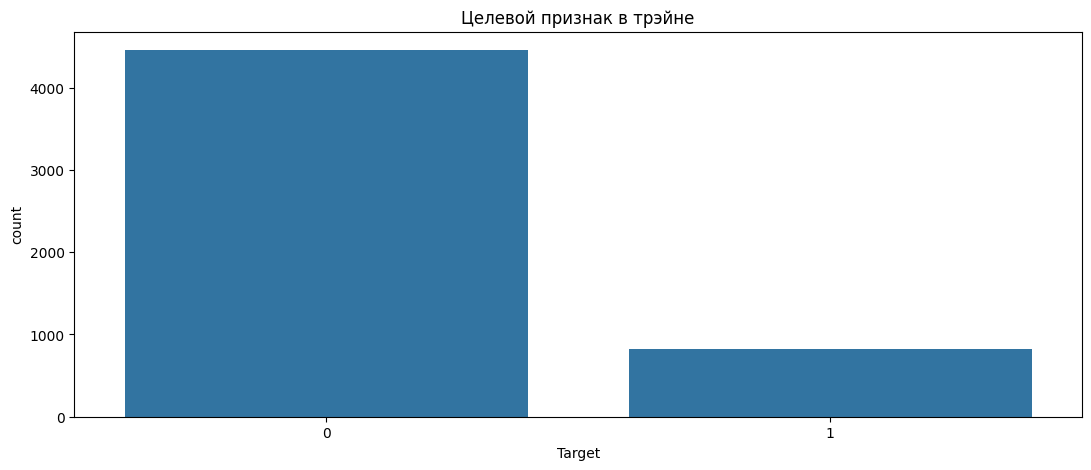

In [19]:
plt.figure(figsize=(13,5));
sns.countplot(data=df_train, x='Target');
plt.title(f"Целевой признак в трэйне")
plt.show()

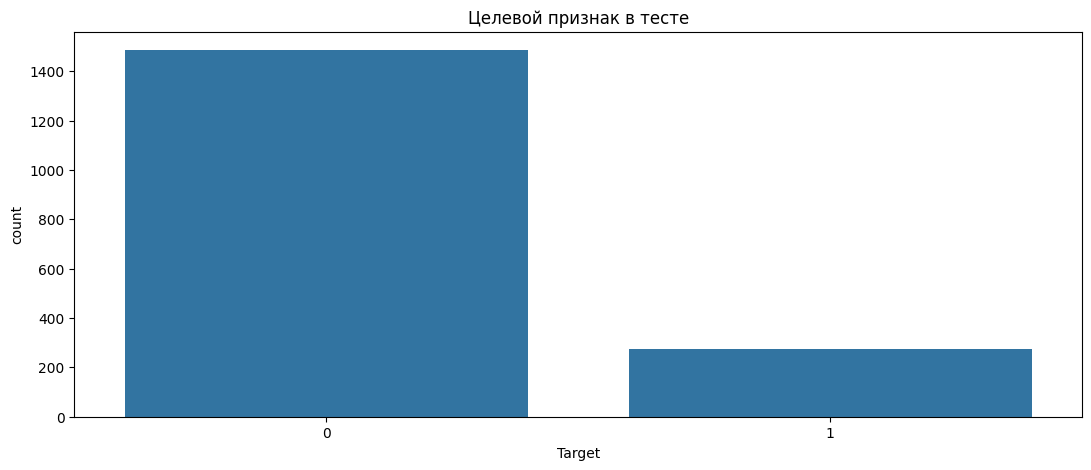

In [20]:
plt.figure(figsize=(13,5));
sns.countplot(data=df_test, x='Target');
plt.title("Целевой признак в тесте")
plt.show()

Как видим, при делении на трейн и тест, пропорция целевого признака сохранилась.

- Данные загруженны и осмотрены. Явные пропуски и явные дубликаты отствуют.
- Требующие этого типы данных были приведены в надлежащий формат.
- Все загруженные таблицы содержат данные.
- Количество таблиц соответствует условию задачи.
- Было принято решение на данном этапе объединить все таблицы с сохранением изначального количества записей в таблице 'contract'.
- Объединеный датасет был сразу поделен на обучающую и тестовую выборки в соотвествии с условиями проекта.

## 2. EDA

### Train

Сразу оценим распределение целевого признака.

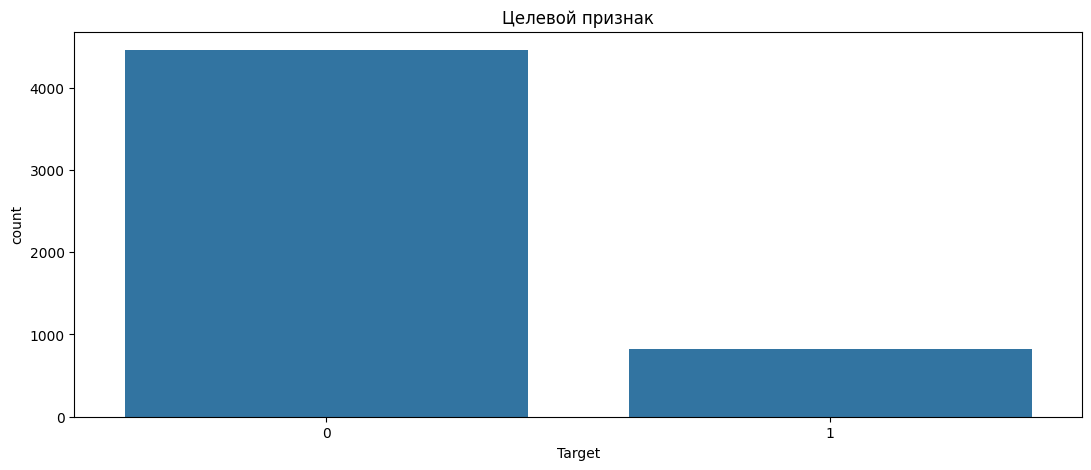

In [21]:
plt.figure(figsize=(13,5));
sns.countplot(data=df_train, x='Target');
plt.title("Целевой признак")
plt.show()

Имеем явный дисбаланс классов

Ознакомимся с категориальными признаками.

In [22]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   Target            7043 non-null   int64  
 7   Duration          7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   object 
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [23]:
df_train.describe(include=['object','datetime'])

,customerID,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282
unique,5282,3,2,4,2,2,2,2,3,3,3,3,3,3,3,3
top,3521-MNKLV,Month-to-month,Yes,Electronic check,Male,0,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,2913,3135,1791,2662,4436,2715,3701,2336,2643,2314,2319,2604,2090,2071,2519


In [24]:
def features(data,type_of_features,hue=None):
    if type_of_features == 'object':
        feature_list = list(data.select_dtypes(include=['object','datetime']).columns)[3:]
        #feature_list.append('year')
        for i in feature_list:
            plt.figure(figsize=(13,5));
            sns.countplot(data=data,hue=hue,x=i);
            plt.xticks(rotation=45)
            plt.title(i)
            plt.show()
    elif type_of_features == 'number':
        data = data[data['TotalCharges'] != -999]
        feature_list = list(data.drop(['Target'],axis=1).select_dtypes(include='number').columns)
        for i in feature_list:
            plt.figure(figsize=(13,5));
            sns.histplot(data, x=i, bins='sturges' ,kde=False);
            plt.xticks(rotation=45)
            plt.title(i)
            plt.show()
            sns.boxplot(data=data[i])
            plt.show()
    else:
        print('Некорретный вариант')        

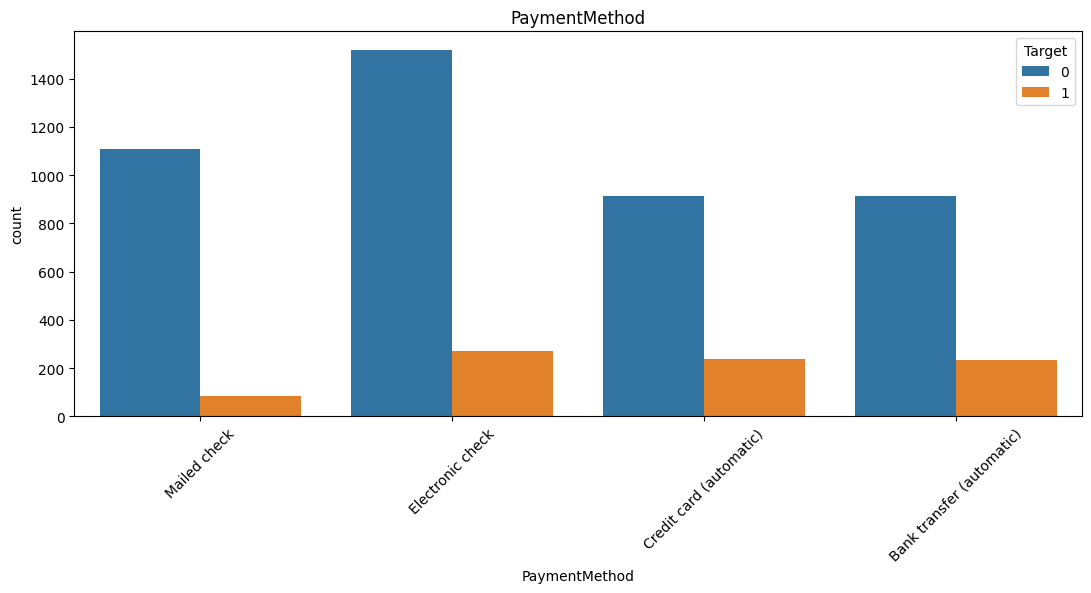

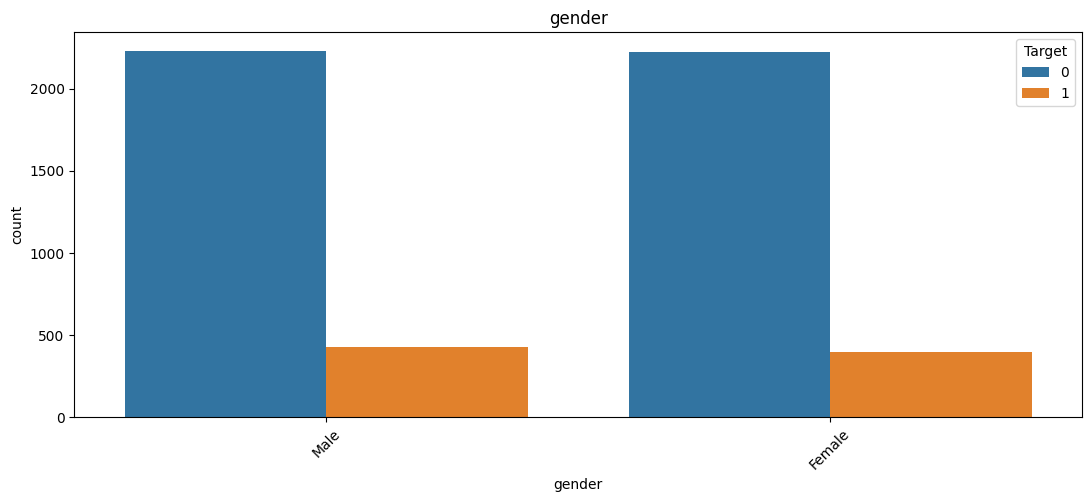

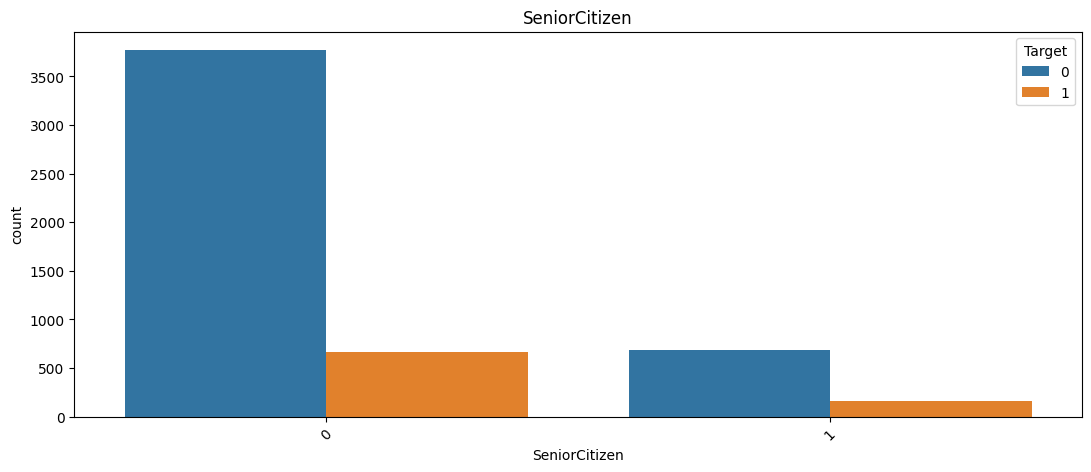

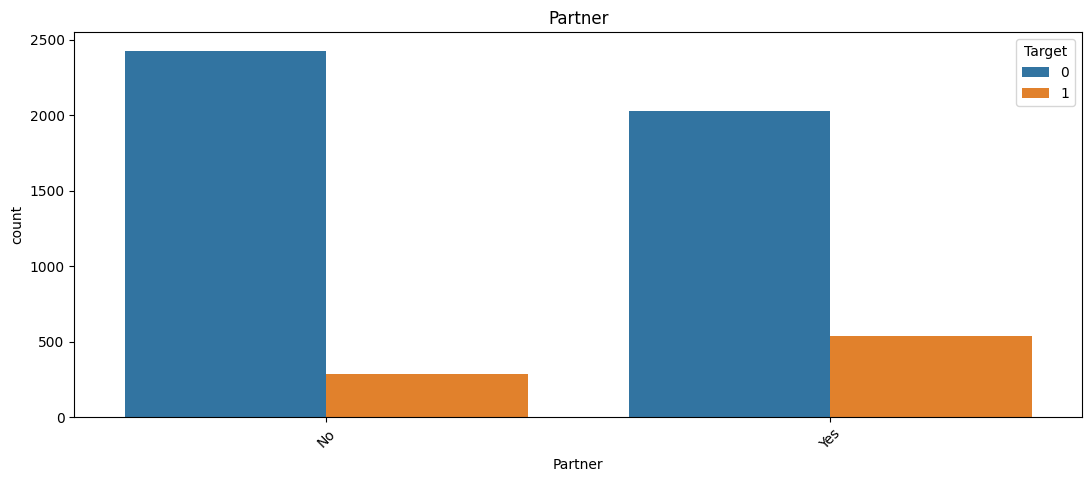

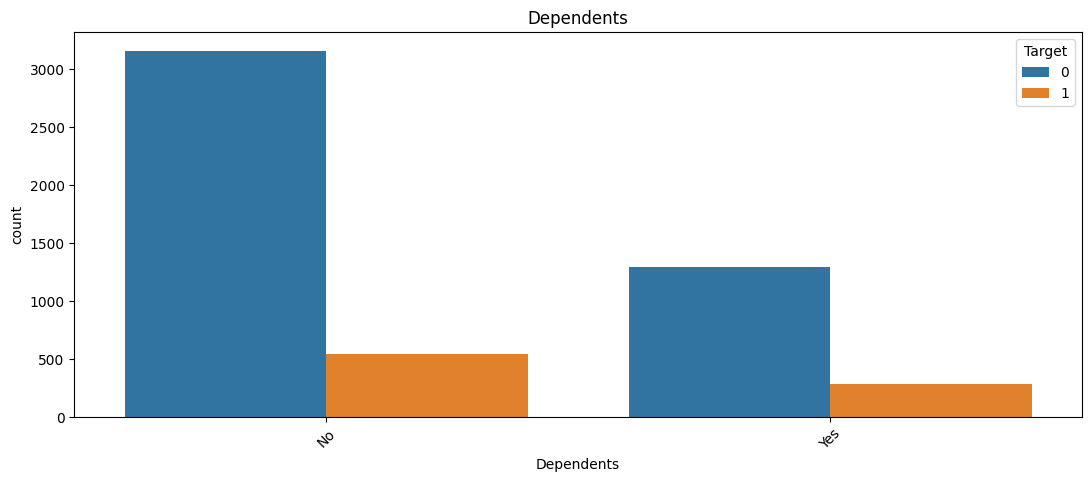

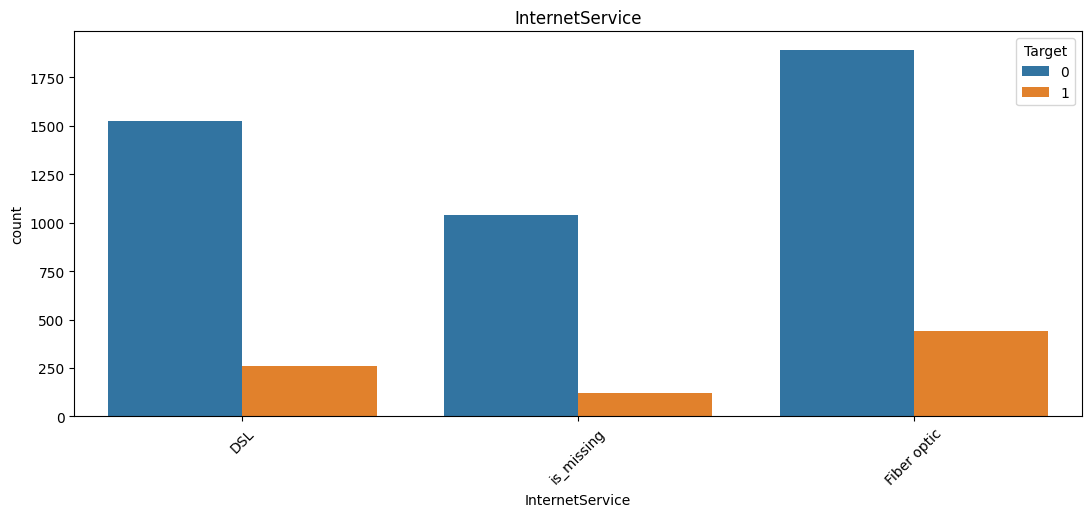

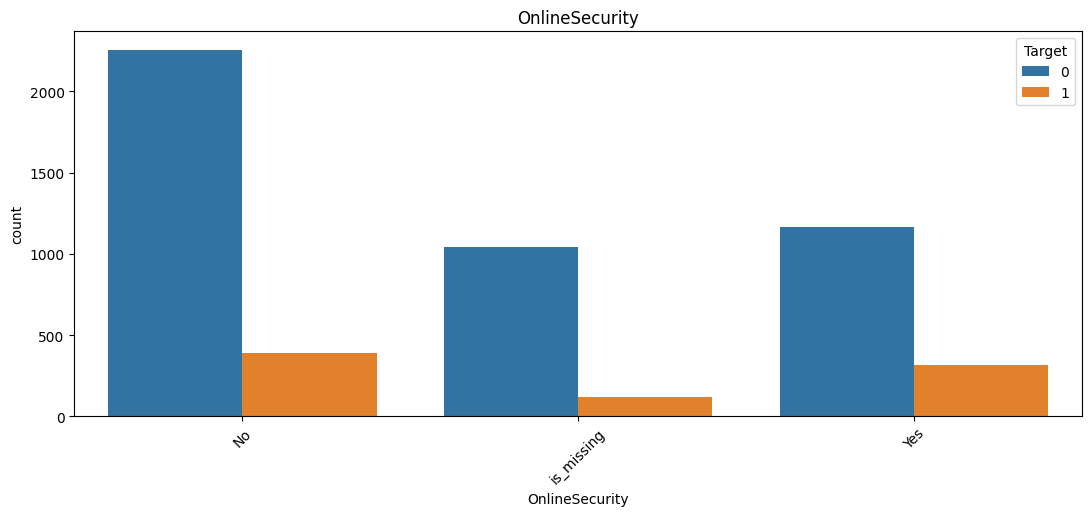

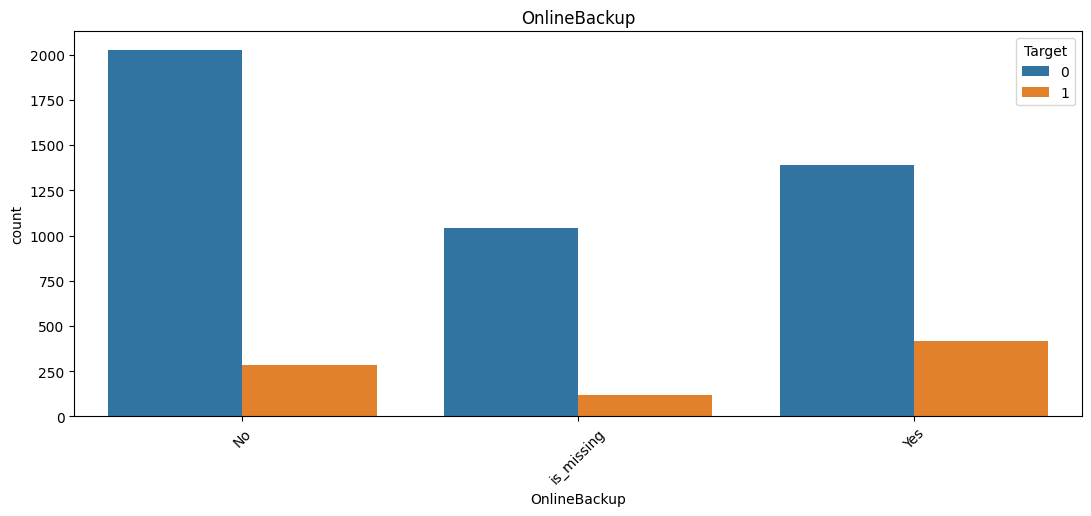

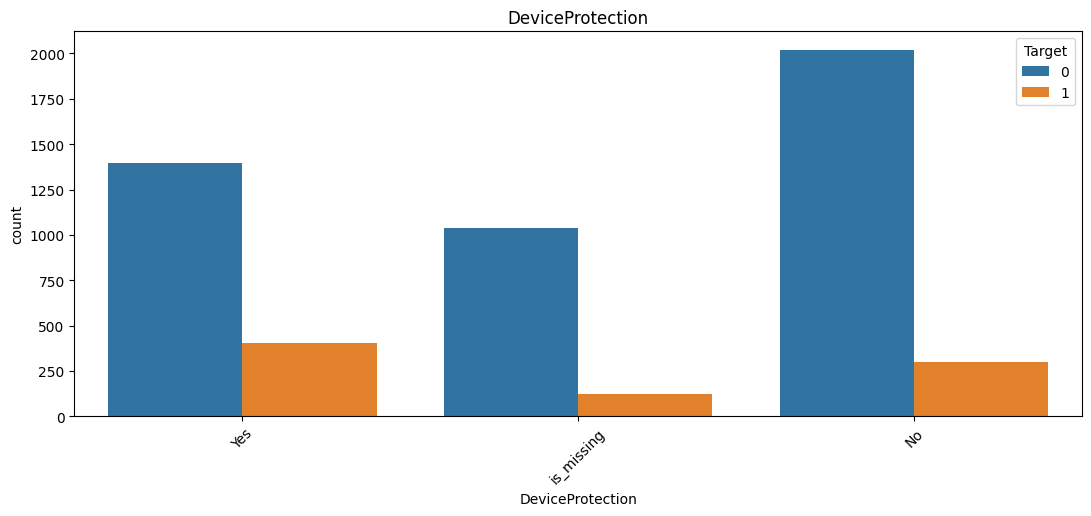

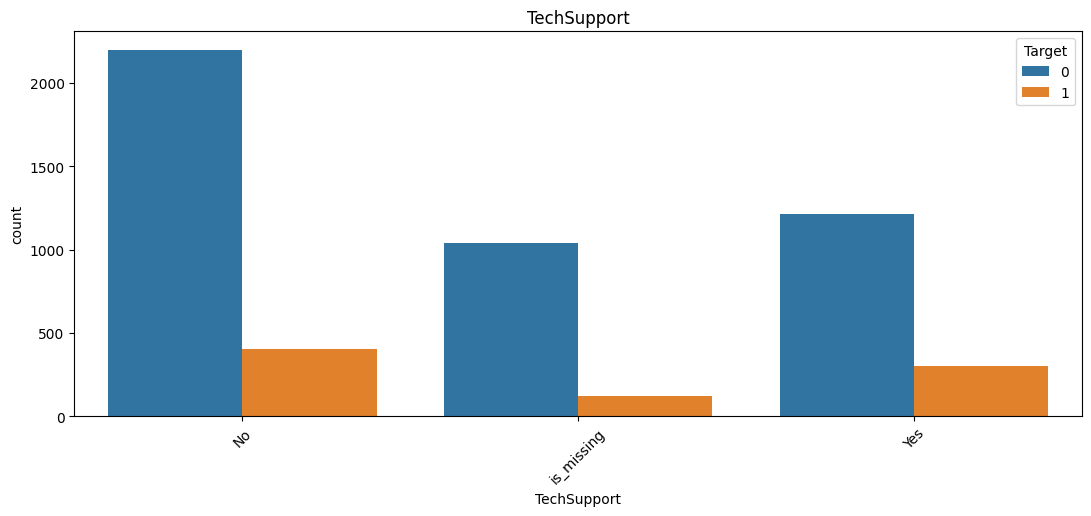

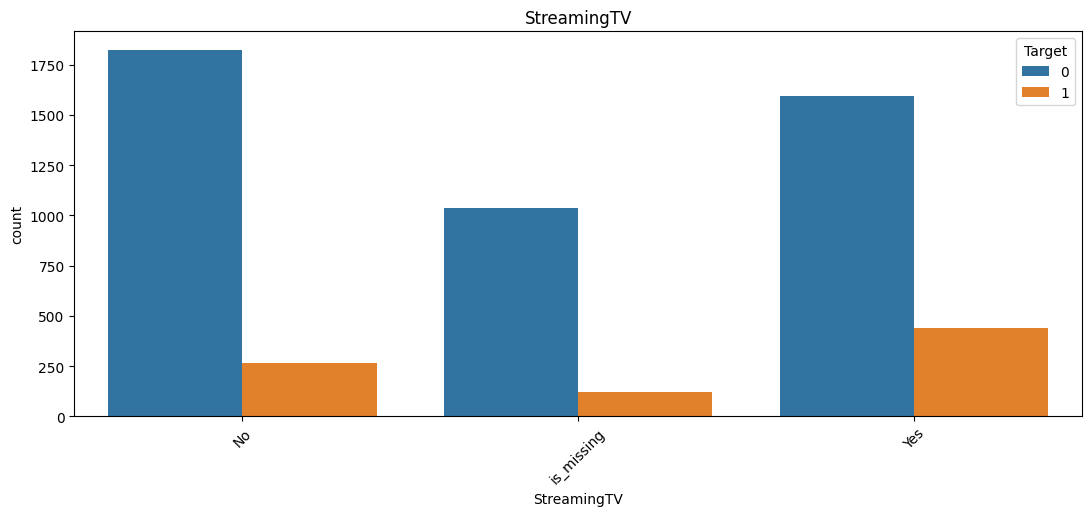

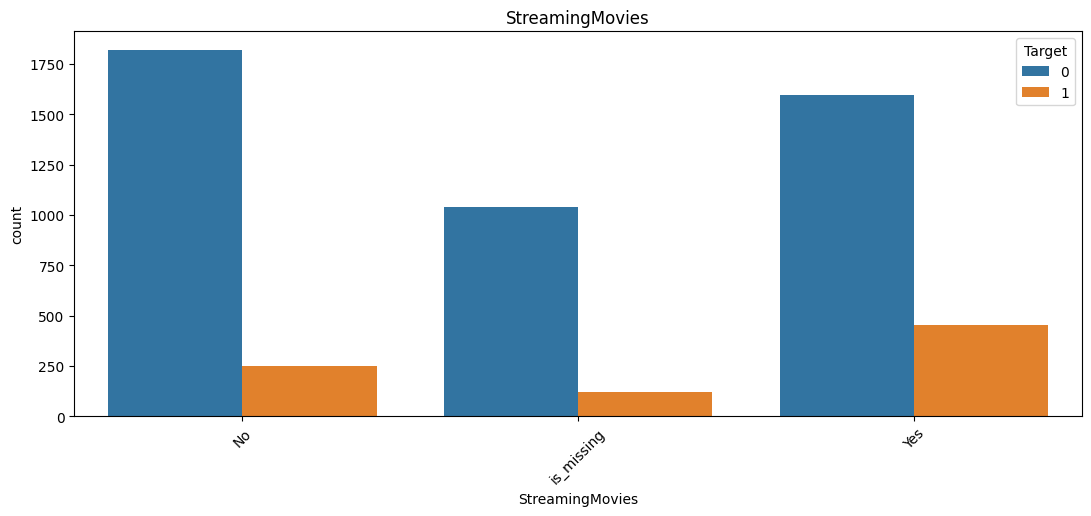

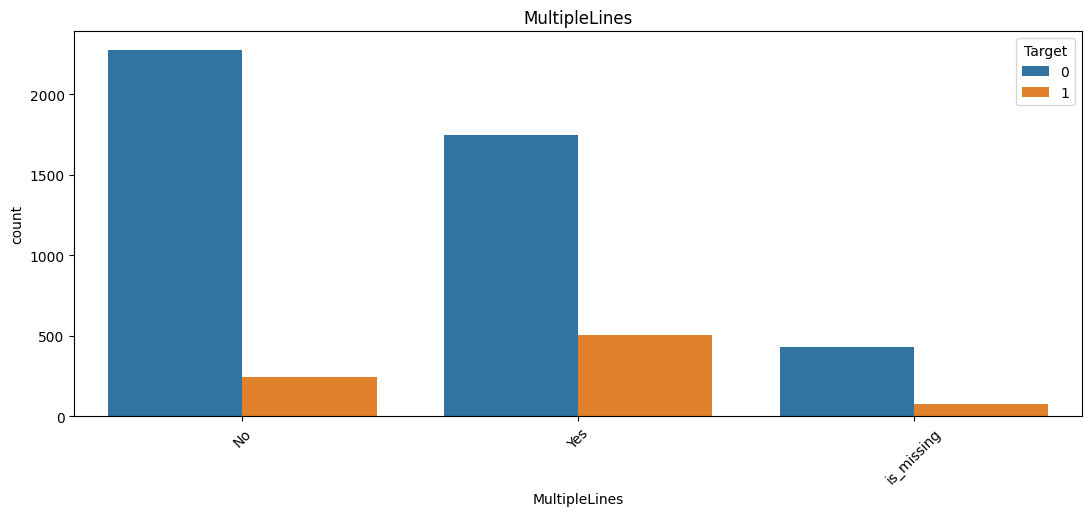

In [25]:
features(df_train,'object',hue='Target')

In [26]:
# Доли отключившихся в зависимости от того, какой формат оплаты по времени.
df_train.groupby(['Type', 'Target'])['customerID'].count() / df_train.groupby(['Type'])['customerID'].count()

Type            Target
Month-to-month  0         0.898387
                1         0.101613
One year        0         0.778881
                1         0.221119
Two year        0         0.773989
                1         0.226011
Name: customerID, dtype: float64

In [27]:
# Доли отключившихся в зависимости от того, есть ли у пользователя доступ к резервному копированию данных.
df_train.groupby(['OnlineBackup', 'Target'])['customerID'].count() / df_train.groupby(['OnlineBackup'])['customerID'].count()

OnlineBackup  Target
No            0         0.875972
              1         0.124028
Yes           0         0.768805
              1         0.231195
is_missing    0         0.895690
              1         0.104310
Name: customerID, dtype: float64

In [28]:
# Доли отключившихся в зависимости от того, есть ли у пользователя доступ к стриминговому ТВ.
df_train.groupby(['StreamingTV', 'Target'])['customerID'].count() / df_train.groupby(['StreamingTV'])['customerID'].count()

StreamingTV  Target
No           0         0.872727
             1         0.127273
Yes          0         0.783957
             1         0.216043
is_missing   0         0.895690
             1         0.104310
Name: customerID, dtype: float64

In [29]:
# Доли отключившихся в зависимости от того, есть ли у польхователя блокировка опасных сайтов.
df_train.groupby(['OnlineSecurity', 'Target'])['customerID'].count() / df_train.groupby(['OnlineSecurity'])['customerID'].count()

OnlineSecurity  Target
No              0         0.853197
                1         0.146803
Yes             0         0.785666
                1         0.214334
is_missing      0         0.895690
                1         0.104310
Name: customerID, dtype: float64

In [30]:
df_train.groupby(['gender', 'Target'])['customerID'].count() / df_train.groupby(['gender'])['customerID'].count()

gender  Target
Female  0         0.848855
        1         0.151145
Male    0         0.838467
        1         0.161533
Name: customerID, dtype: float64

In [31]:
# Доли отключившихся в зависимости от того, есть ли у польхователя супруг или супруга.
df_train.groupby(['Partner', 'Target'])['customerID'].count() / df_train.groupby(['Partner'])['customerID'].count()

Partner  Target
No       0         0.894291
         1         0.105709
Yes      0         0.790027
         1         0.209973
Name: customerID, dtype: float64

In [32]:
# Доли отключившихся в зависимости от того, является ли пользователь пенсионером.
df_train.groupby(['SeniorCitizen', 'Target'])['customerID'].count() / df_train.groupby(['SeniorCitizen'])['customerID'].count()

SeniorCitizen  Target
0              0         0.850541
               1         0.149459
1              0         0.807329
               1         0.192671
Name: customerID, dtype: float64

In [33]:
# Доли отключившихся в зависимости от наличия доступа к каталогу фильмов.
df_train.groupby(['StreamingMovies', 'Target'])['customerID'].count() / df_train.groupby(['StreamingMovies'])['customerID'].count()

StreamingMovies  Target
No               0         0.879285
                 1         0.120715
Yes              0         0.778157
                 1         0.221843
is_missing       0         0.895690
                 1         0.104310
Name: customerID, dtype: float64

In [34]:
# Доли отключившихся в зависимости от подключения телефона к нескольким линиям одновременно.
df_train.groupby(['MultipleLines', 'Target'])['customerID'].count() / df_train.groupby(['MultipleLines'])['customerID'].count()


MultipleLines  Target
No             0         0.903533
               1         0.096467
Yes            0         0.776053
               1         0.223947
is_missing     0         0.846457
               1         0.153543
Name: customerID, dtype: float64

Количественные признаки

In [35]:
df_train[df_train['TotalCharges'] != -999].drop(['Target'],axis=1).describe(include='number')

,MonthlyCharges,TotalCharges,Duration
count,5282.000000,5282.000000,5282.000000
mean,64.720759,2111.325750,899.819197
std,30.225395,2108.993487,683.260115
min,18.250000,0.000000,0.000000
25%,35.000000,445.562500,276.000000
50%,70.400000,1352.550000,761.000000
75%,89.987500,3208.487500,1461.000000
max,118.650000,9221.380000,2314.000000


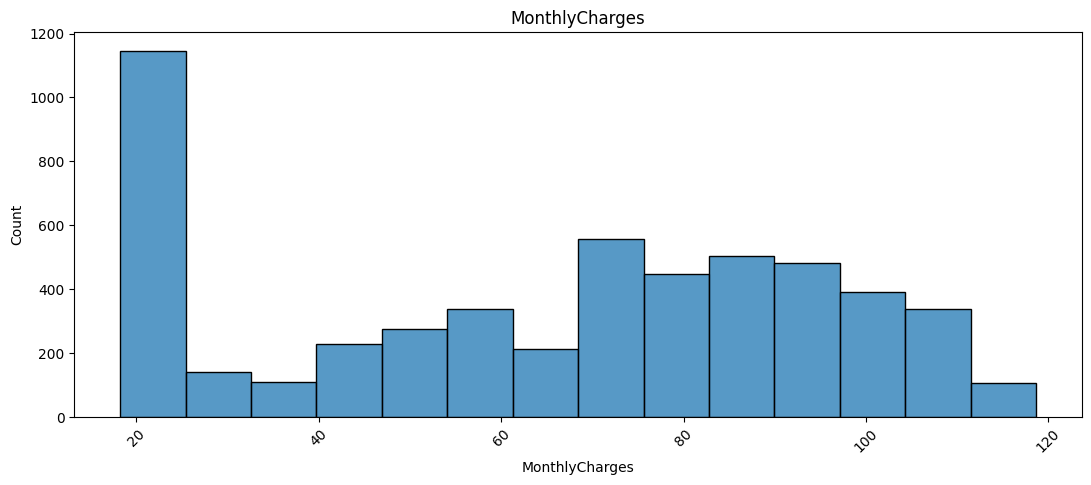

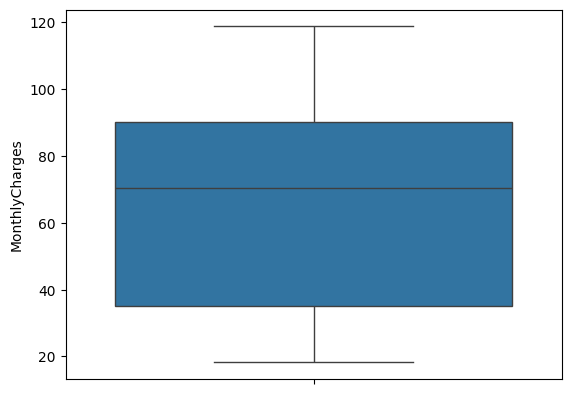

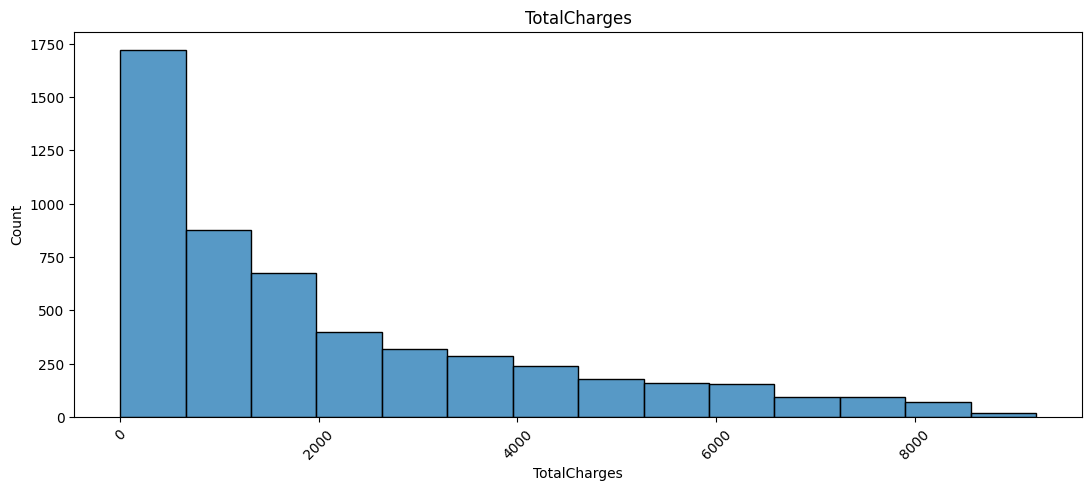

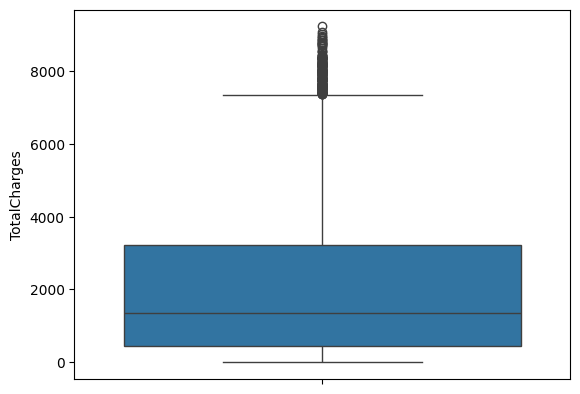

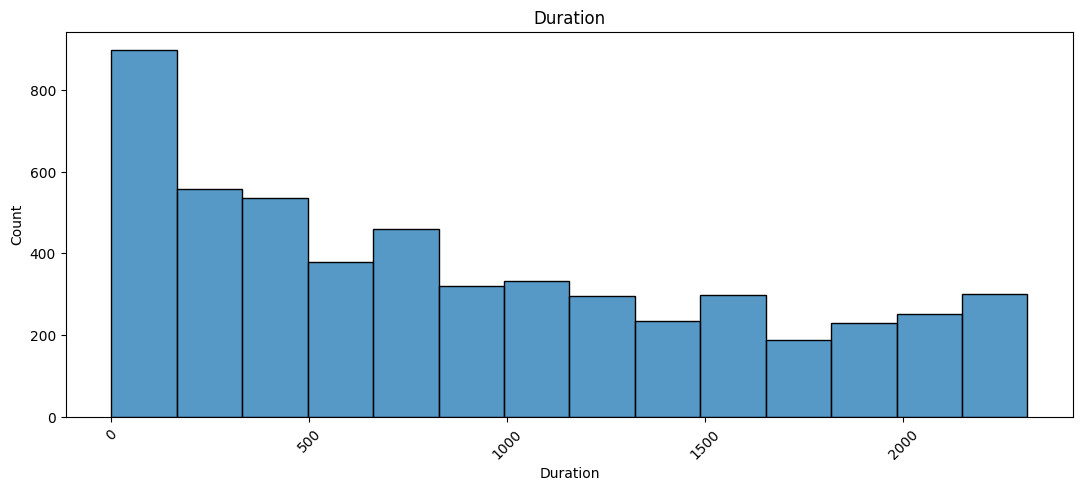

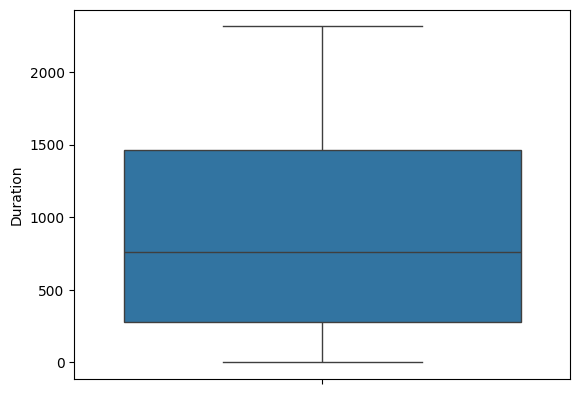

In [36]:
features(df_train,'number',hue='Target')

Оба признака имеют ассиметричное распределение. В признаке 'TotalCharges' имеются выбросы.

In [37]:
phik_corr_train = df_train.drop(['customerID'],axis=1).phik_matrix(interval_cols=['MonthlyCharges','TotalCharges','Duration'])

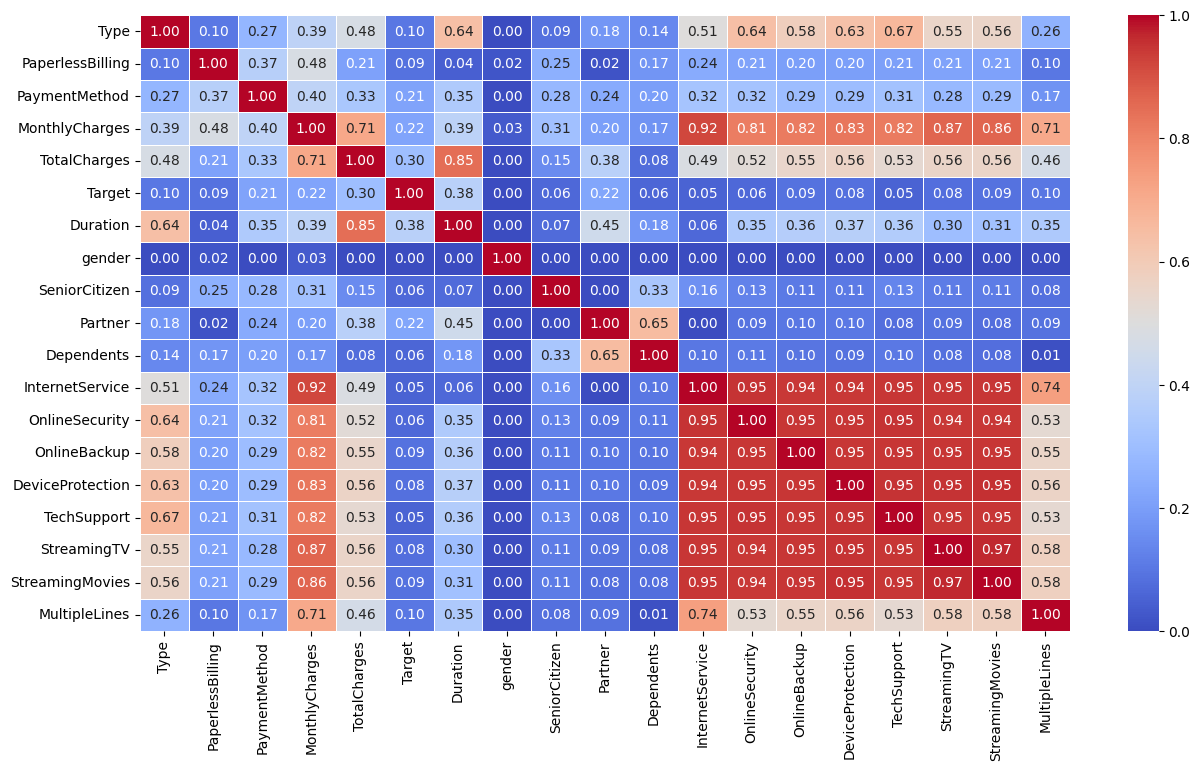

In [38]:
plt.figure(figsize=(15, 8))

# Строим тепловую карту
sns.heatmap(phik_corr_train, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Отображаем график
plt.show()

Данные признаки обладают крайне выраженной зависимостью с признаком StreamingTV: InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovie. И доли отвалившихся\оставшився в этих признаках практически идентичны.

По результам EDA имеем следующие выводы:

Категориальные признаки:
- Сгенерированый признак 'year' наглядно демонстрирует, что чем раньше человек стал клиентом, тем выше вероятность того, что он уйдет. Из графика видно, что от года к году количество новых клиентов растет, и количество отвалившихся падает. Поэтому выделим его в самостоятельный признак.
- Доля отвалившихся клиентов среди подключивших телефон к нескольким линиям одновременно, выше, чем без данной услуги (23 процента против 9)
- Данные признаки обладают крайне выраженной линейной зависимостью с признаком StreamingTV: InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovie. И доли отвалившихся\оставшився в этих признаках практически идентичны. Уберем их из датасета.
- Уберем признак 'gender', так как доли в нем практически одинаковые.

Количественные признаки:
- Оба признака имеют ассиметричное распределение. В признаке 'TotalCharges' имеются выбросы. Устраним выбросы.
- Так же матрица корреляции показывает сильную взаимосвязь между данными признаками. И в ходе дальнейшего теста выяснилось, что убрав 'MonthlyCharges' получилось существенно улучшить качество модели.

Преобразуем наш тренировочный датасет с учетом всей полученной информации.

In [39]:
TOTALCHARGES_MEDIAN = df_train['TotalCharges'].median()

In [40]:
# Преобразовываем нужный датасет с учетом EDA
def preproccessing(data):

    Q1 = data['TotalCharges'].quantile(0.25)
    Q3 = data['TotalCharges'].quantile(0.75)
    IQR = Q3 - Q1 

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data.drop(['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                          'StreamingMovies','customerID', 'gender','MonthlyCharges'],axis=1)
    return data

In [41]:
df_train

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4896,3521-MNKLV,Month-to-month,Yes,Mailed check,49.70,1192.80,0,730,Male,0,No,No,DSL,No,No,Yes,No,No,No,No
6492,9548-LERKT,Two year,No,Mailed check,19.75,483.48,0,730,Male,0,Yes,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
2504,8433-WXGNA,Month-to-month,Yes,Electronic check,75.70,229.37,0,92,Male,0,No,No,Fiber optic,Yes,No,No,No,No,No,No
6081,8757-TFHHJ,Month-to-month,Yes,Credit card (automatic),49.80,51.29,0,31,Male,0,No,No,DSL,Yes,No,No,No,No,No,No
3366,1855-AGAWH,One year,Yes,Electronic check,93.80,3082.27,0,945,Male,0,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,7140-ADSMJ,Month-to-month,Yes,Credit card (automatic),20.45,163.60,0,245,Male,0,No,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
5973,2324-EFHVG,Two year,Yes,Bank transfer (automatic),104.40,5950.80,1,1734,Male,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4119,6016-NXBNJ,One year,Yes,Mailed check,19.15,697.06,0,1067,Male,0,No,No,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No
6000,9503-XJUME,One year,No,Credit card (automatic),19.65,1021.80,0,1584,Male,0,No,Yes,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,is_missing,No


In [42]:
df_train = preproccessing(df_train)

In [43]:
display(df_train.head())
display(df_train.info())

,Type,PaperlessBilling,PaymentMethod,TotalCharges,Target,Duration,SeniorCitizen,Partner,Dependents,StreamingTV,MultipleLines
4896,Month-to-month,Yes,Mailed check,1192.80,0,730,0,No,No,No,No
6492,Two year,No,Mailed check,483.48,0,730,0,Yes,No,is_missing,No
2504,Month-to-month,Yes,Electronic check,229.37,0,92,0,No,No,No,No
6081,Month-to-month,Yes,Credit card (automatic),51.29,0,31,0,No,No,No,No
3366,One year,Yes,Electronic check,3082.27,0,945,0,Yes,No,Yes,No


<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 4896 to 220
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   TotalCharges      5282 non-null   float64
 4   Target            5282 non-null   int64  
 5   Duration          5282 non-null   int64  
 6   SeniorCitizen     5282 non-null   object 
 7   Partner           5282 non-null   object 
 8   Dependents        5282 non-null   object 
 9   StreamingTV       5282 non-null   object 
 10  MultipleLines     5282 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 495.2+ KB


None

### Test

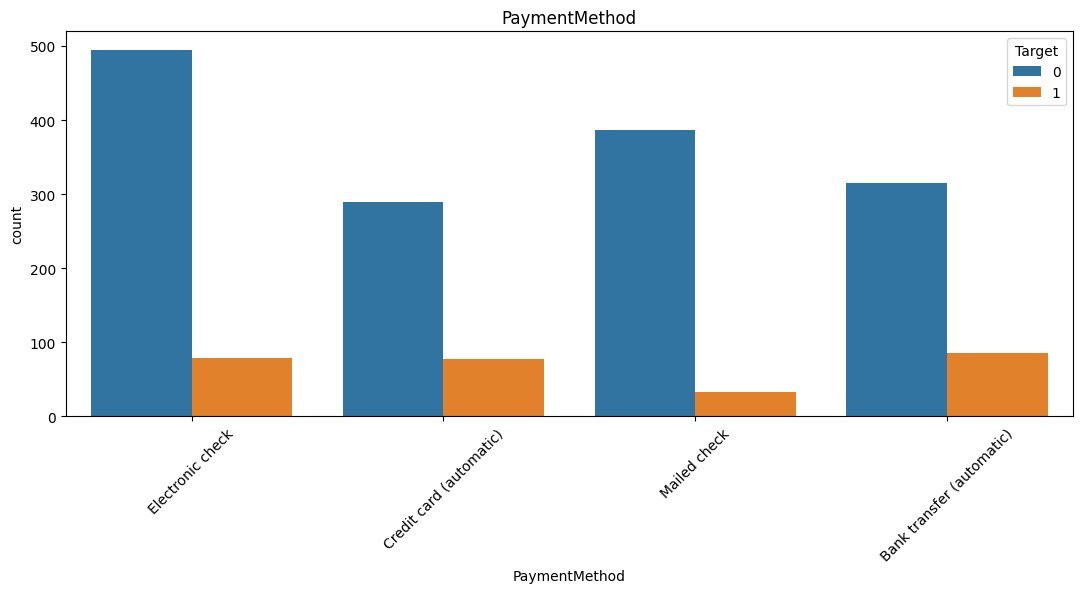

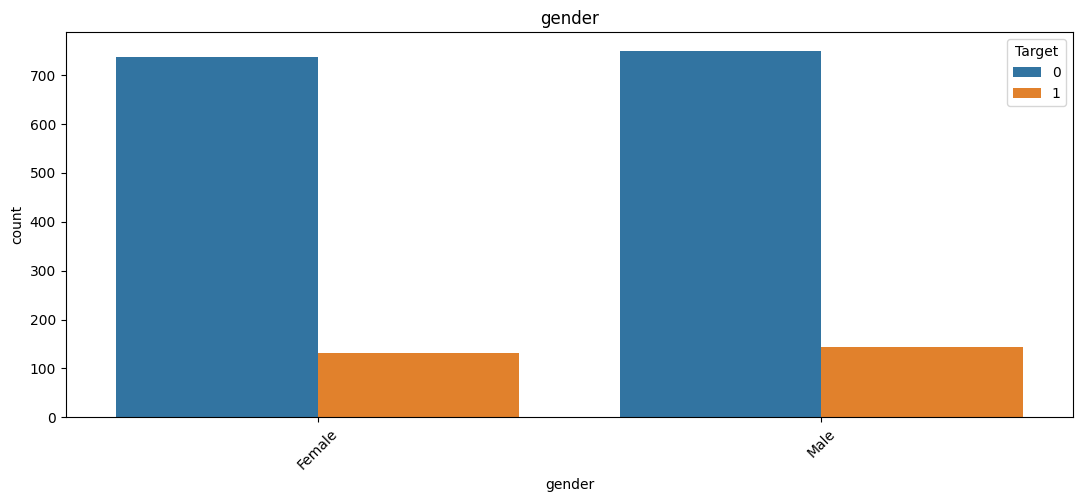

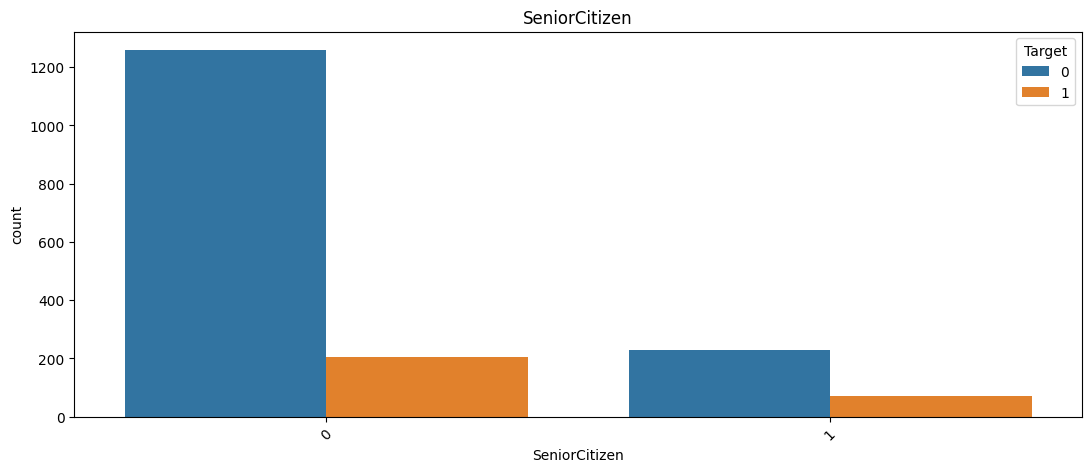

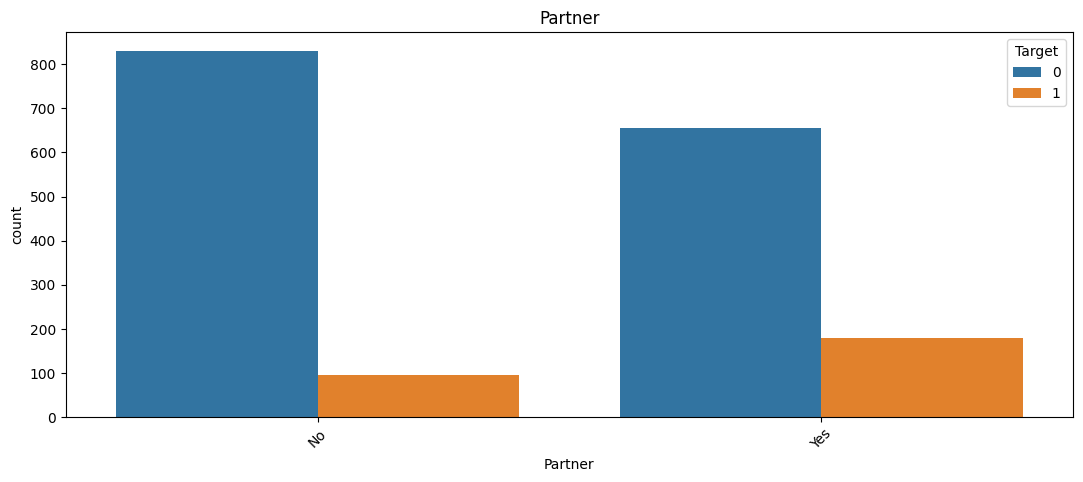

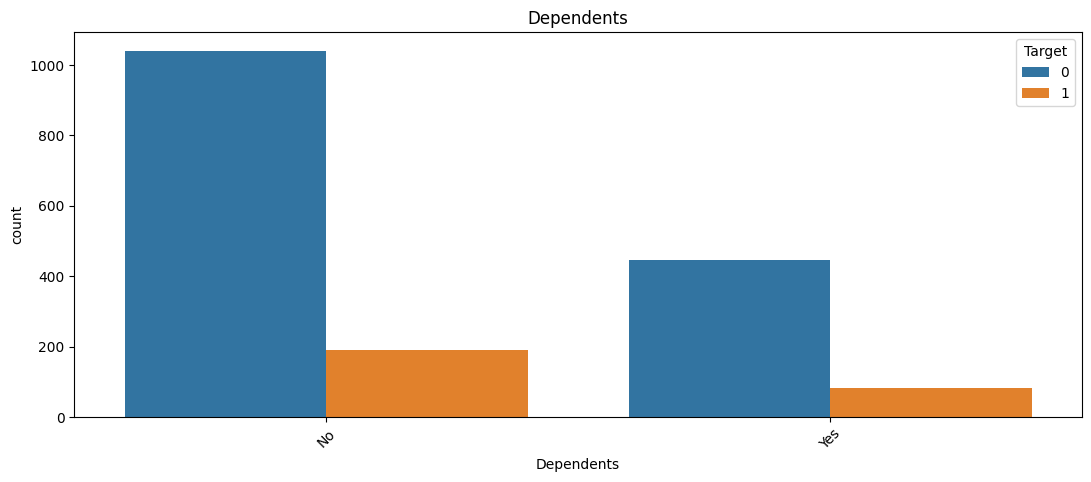

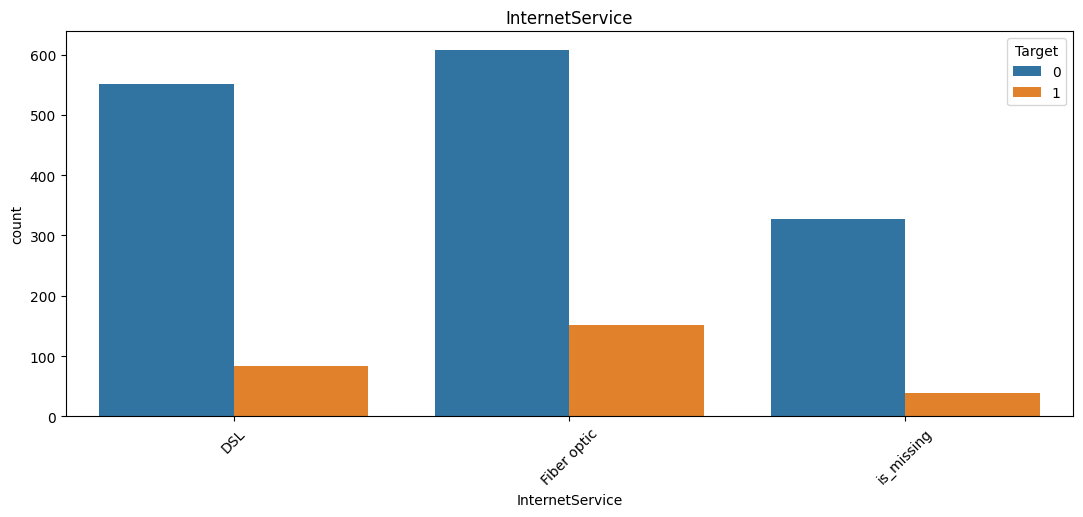

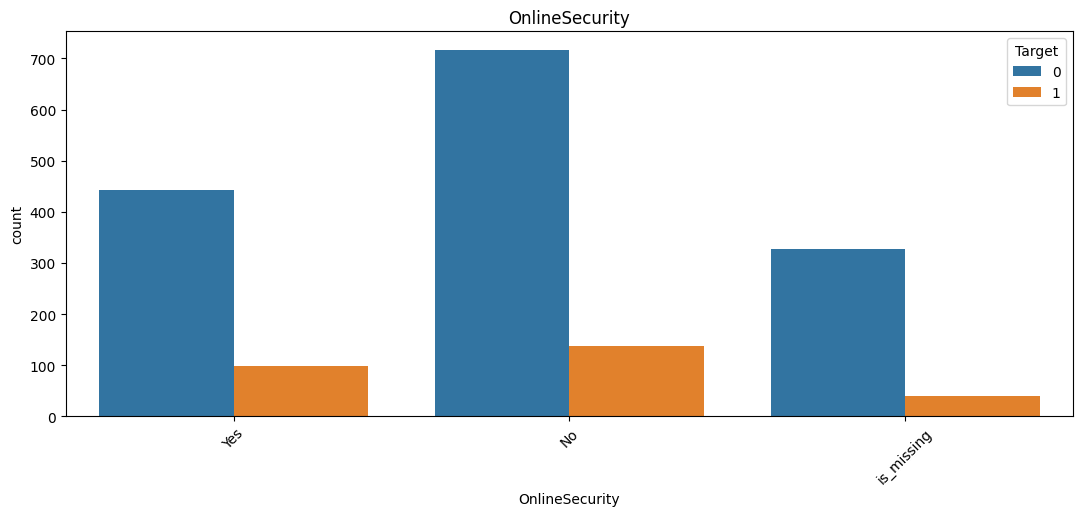

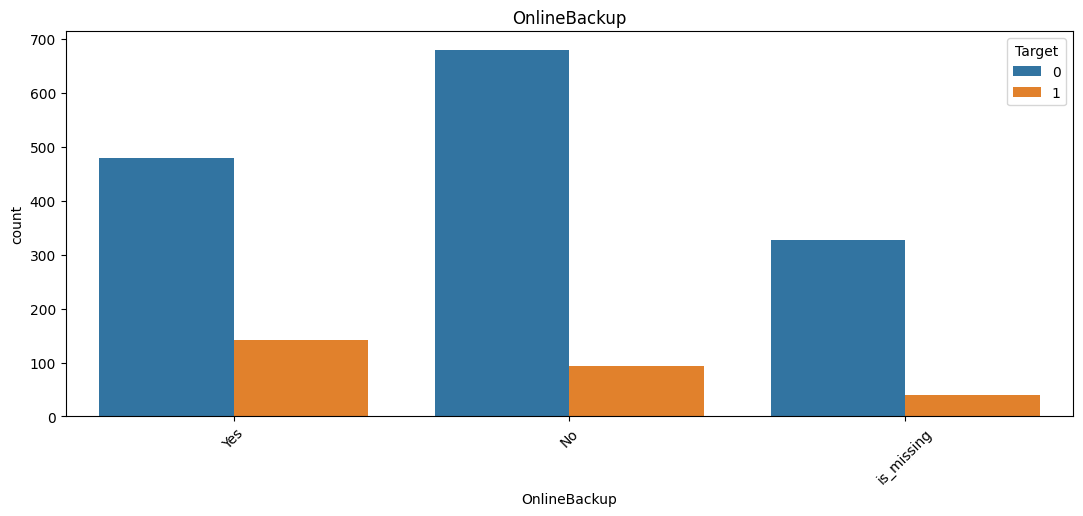

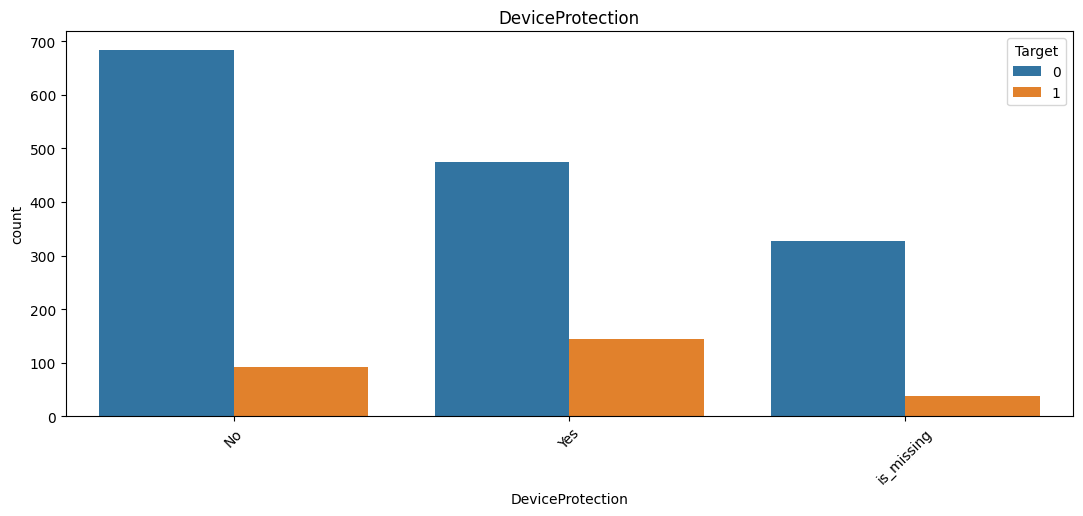

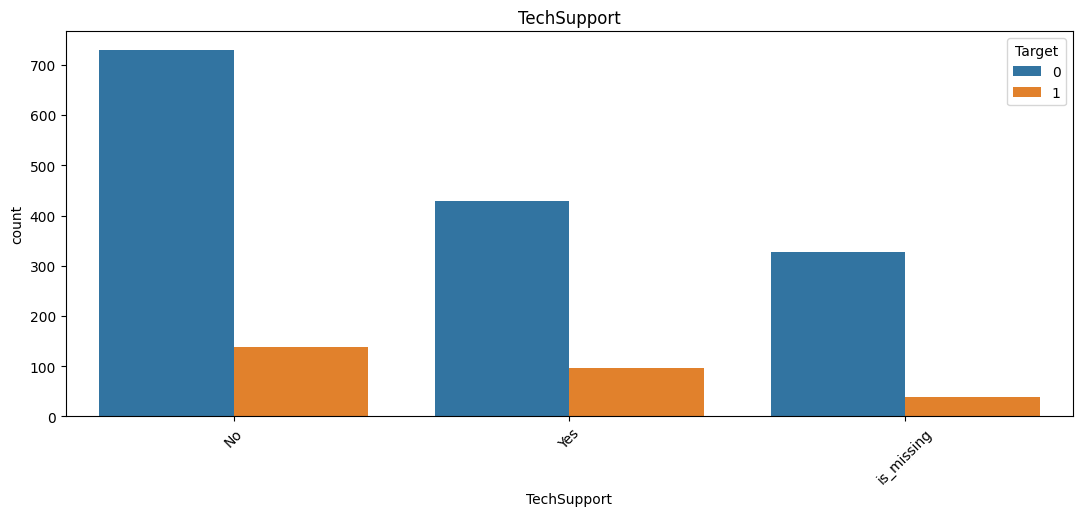

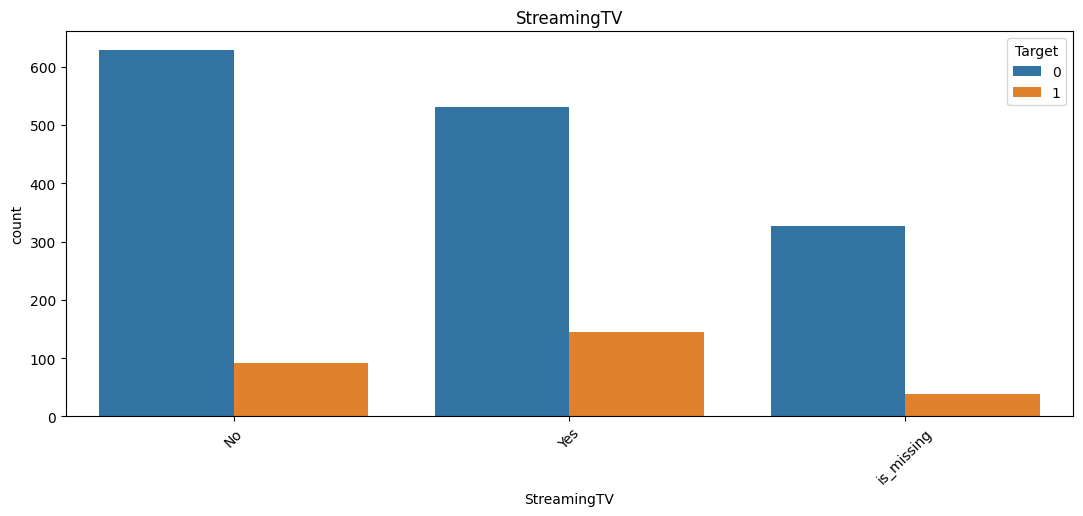

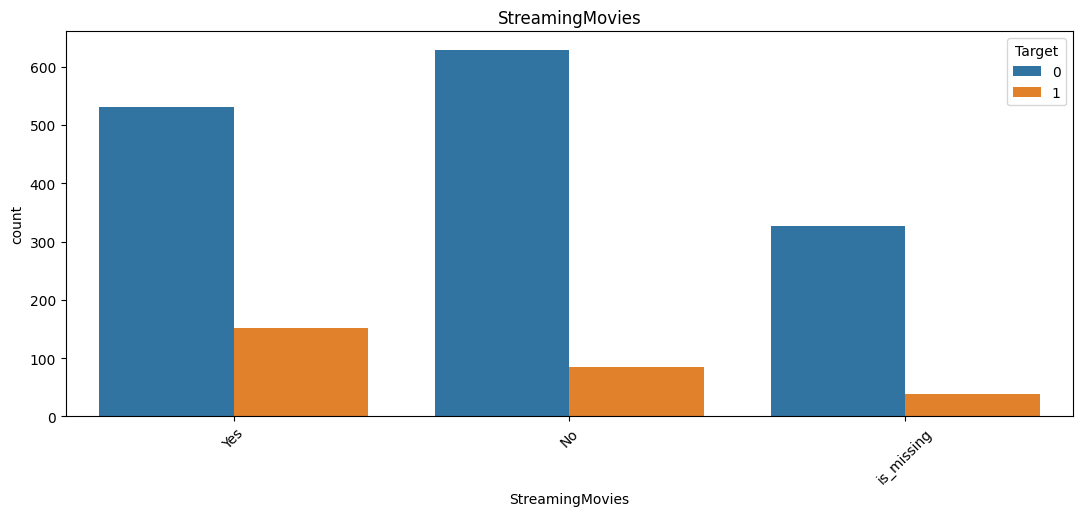

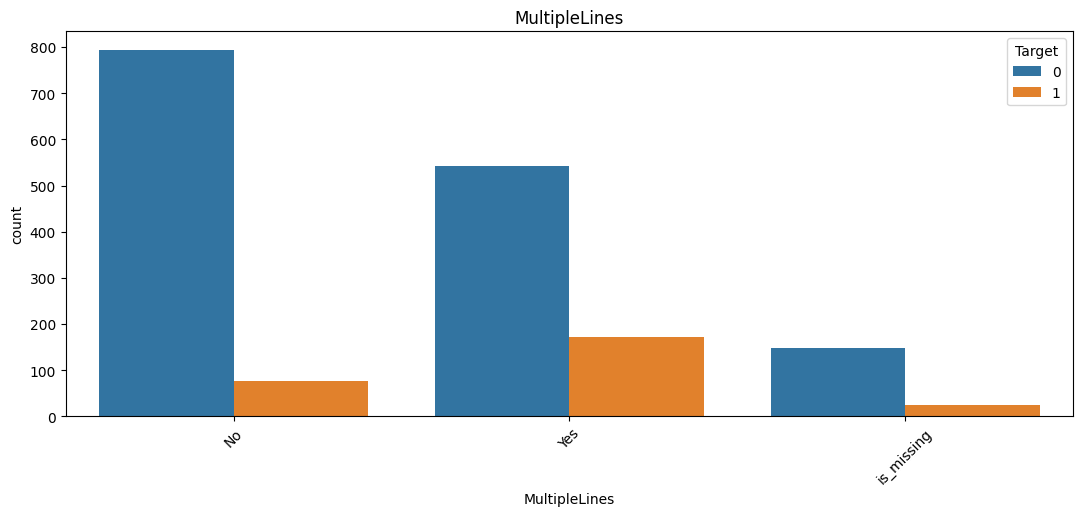

In [44]:
features(df_test,'object',hue='Target')

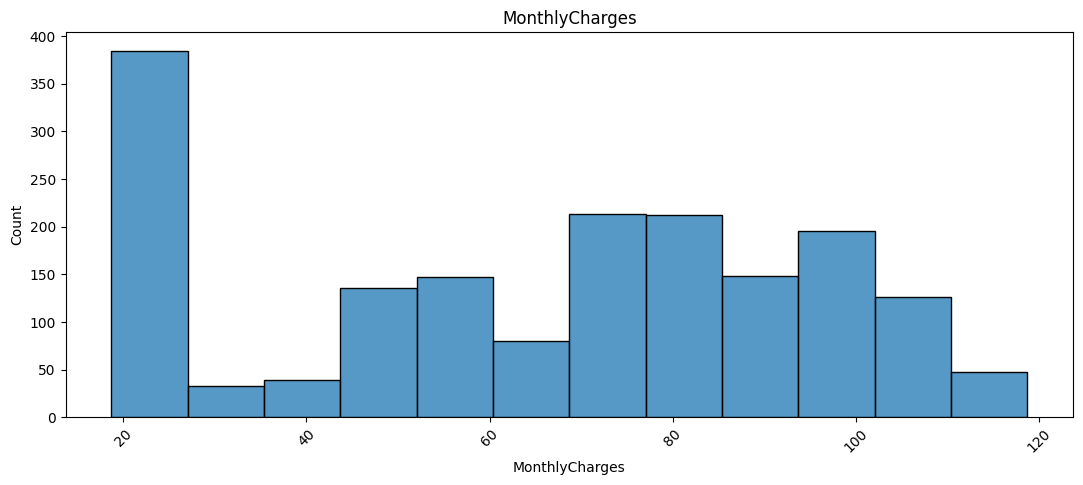

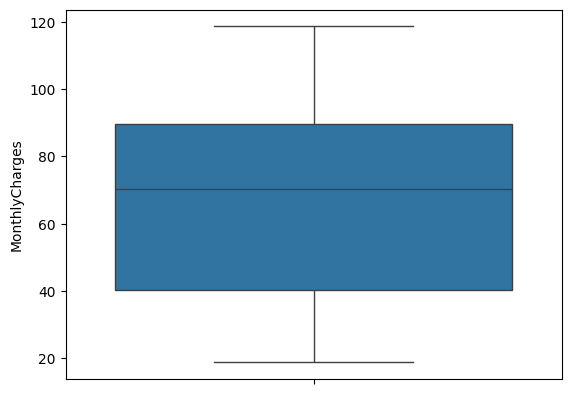

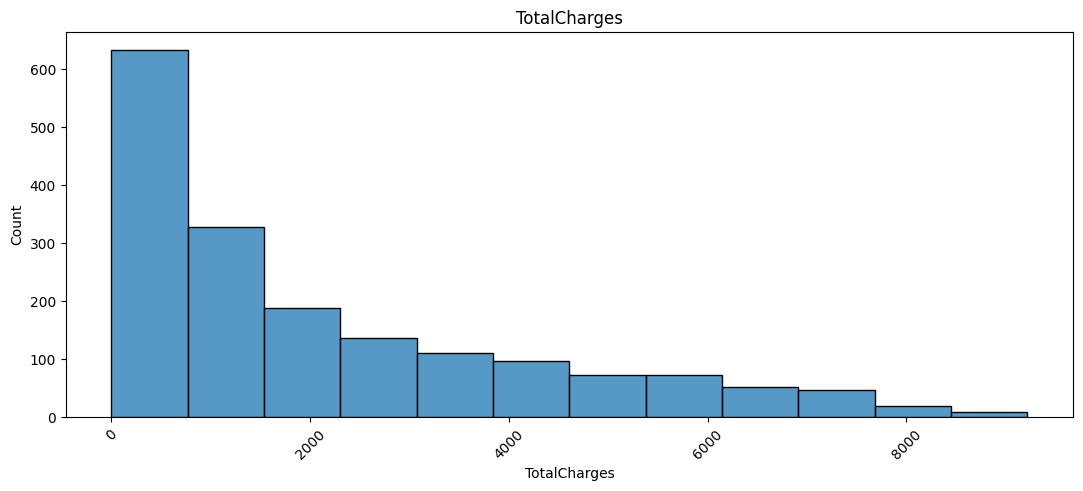

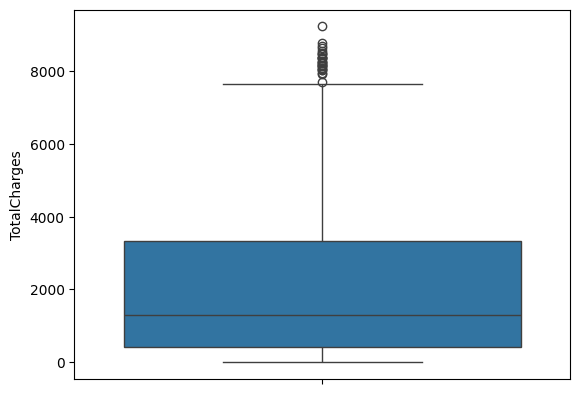

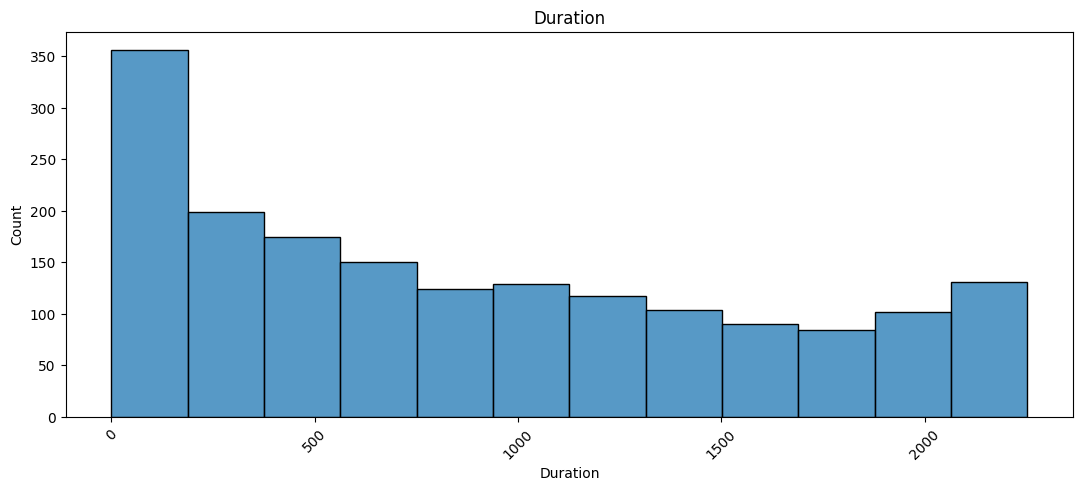

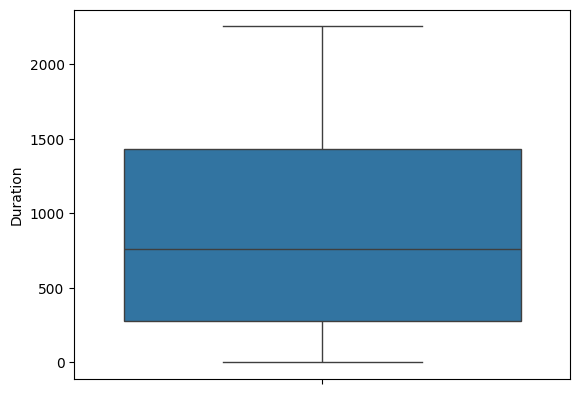

In [45]:
features(df_test,'number',hue='Target')

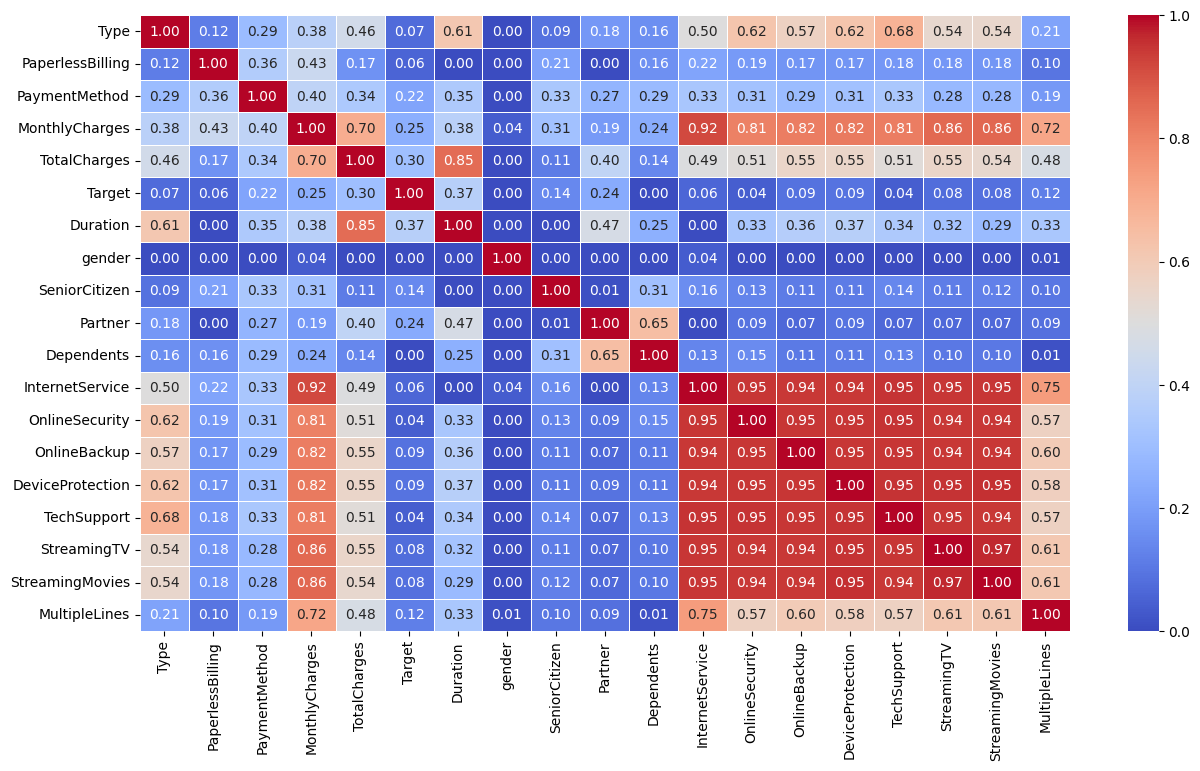

In [46]:
phik_corr_test = df_test.drop(['customerID'],axis=1).phik_matrix(interval_cols=['MonthlyCharges','TotalCharges','Duration'])
plt.figure(figsize=(15, 8))

# Строим тепловую карту
sns.heatmap(phik_corr_test, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Отображаем график
plt.show()

По итогам EDA, тренировончые и тестовые выборки однородны.

## 3. Подбор оптимальной модели.

В начале протестирую LGBM и RandomForest. Кодировать буду OrdinalEncoder-ом. Нормальзацию или стандартизацию проводить нет буду, так как это 'деревянные' модели.

In [47]:
X_train = df_train.drop('Target',axis=1)
y_train = df_train['Target']

Посмотрим, как ведет себя дамми-модель.

In [48]:
X_dummy_train, X__dummy_test, y_dummy_train, y_dummy_test = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE,stratify=y_train)

In [49]:
dummy_model = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)

dummy_model.fit(X_dummy_train, y_dummy_train)

y_pred_proba = dummy_model.predict_proba(X__dummy_test)[:, 1]


roc_auc = roc_auc_score(y_dummy_test, y_pred_proba)
print(f"ROC AUC дамми-модели: {roc_auc:.4f}")

ROC AUC дамми-модели: 0.5000


In [52]:
def optimize_lgbm(X, y, n_trials=50):

    def objective(trial):
        # 1. Настройка гиперпараметров через Optuna
        lgbm_model = lgb.LGBMClassifier(
            objective='binary',
            boosting_type=trial.suggest_categorical('boosting_type', ['dart', 'gbdt', 'rf']),
            subsample=trial.suggest_float('subsample', 0.05, 1.0),
            subsample_freq=trial.suggest_int('subsample_freq', 2, 4),
            n_estimators=trial.suggest_int('n_estimators', 10, 300),
            learning_rate=trial.suggest_float('learning_rate', 0.05, 1.0, log=True),
            num_leaves=trial.suggest_int('num_leaves', 2, 16),
            max_depth=trial.suggest_int('max_depth', 1, 8),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.05, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 0.5, 5.0),
            reg_lambda=trial.suggest_float('reg_lambda', 0.5, 5.0),
            is_unbalance=True,
            random_state=RANDOM_STATE,
            verbose=-1
        )

        # 2. Кросс-валидация (5 фолдов)
        categorical_columns = X.select_dtypes(include=['object', 'category']).columns
        
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        X_encoded = X.copy()
        X_encoded[categorical_columns] = encoder.fit_transform(X[categorical_columns])

        # Используем cross_val_score для кросс-валидации
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        auc_scores = cross_val_score(lgbm_model, X_encoded, y, cv=skf, scoring='roc_auc', n_jobs=-1)

        # Возвращаем средний ROC AUC по фолдам
        return np.mean(auc_scores)

    # Создание Optuna Study
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=RANDOM_STATE))  # Оптимизируем ROC AUC (максимизация)

    # Запуск оптимизации
    study.optimize(objective, n_trials=n_trials)

    print("Лучшие гиперпараметры:", study.best_params)
    print("Лучший ROC AUC:", study.best_value)

    return study

In [53]:
start_time = time.time()

study_LGBM = optimize_lgbm(X_train, y_train, n_trials=20)
LGBM_best_param = study_LGBM.best_params
LGBM_result = study_LGBM.best_value

end_time = time.time()
LGBM_train_time = end_time - start_time

Лучшие гиперпараметры: {'boosting_type': 'gbdt', 'subsample': 0.86780424354784, 'subsample_freq': 2, 'n_estimators': 289, 'learning_rate': 0.7212604789295974, 'num_leaves': 13, 'max_depth': 8, 'colsample_bytree': 0.538333513499585, 'reg_alpha': 0.9706037658967509, 'reg_lambda': 3.0522534422497127}
Лучший ROC AUC: 0.8877477221455281


In [54]:
def optimize_RF(X, y, n_trials=20):

    def objective(trial):
        # 1. Настройка гиперпараметров через Optuna
        RF_model = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        max_depth=trial.suggest_int('max_depth', 5, 30),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
        criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
        random_state=RANDOM_STATE
        )
        # 2. Кросс-валидация (5 фолдов)
        categorical_columns = X.select_dtypes(include=['object', 'category']).columns
        
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        X_encoded = X.copy()
        X_encoded[categorical_columns] = encoder.fit_transform(X[categorical_columns])

        # Используем cross_val_score для кросс-валидации
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        auc_scores = cross_val_score(RF_model, X_encoded, y, cv=skf, scoring='roc_auc', n_jobs=-1)

        # Возвращаем средний ROC AUC по фолдам
        return np.mean(auc_scores)

    # Создание Optuna Study
    study = optuna.create_study(direction='maximize',sampler=RandomSampler(seed=RANDOM_STATE))  # Оптимизируем ROC AUC (максимизация)

    # Запуск оптимизации
    study.optimize(objective, n_trials=n_trials)


    print("Лучшие гиперпараметры:", study.best_params)
    print("Лучший ROC AUC:", study.best_value)

    return study

In [55]:
start_time = time.time()

study_RF = optimize_RF(X_train, y_train, n_trials=5)
RF_best_param = study_RF.best_params
RF_result = study_RF.best_value

end_time = time.time()
RF_train_time = end_time - start_time

Лучшие гиперпараметры: {'n_estimators': 195, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy'}
Лучший ROC AUC: 0.8402146820821275


Теперь реализуем простую нейросеть прямого распостранения на Keras.

In [56]:
def build_model(input_dim):
    """Создает простую нейросеть для бинарной классификации"""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32,activation='relu'),
        Dense(1, activation='sigmoid')  # Для бинарной классификации
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

def cross_validate_nn(X, y, n_splits=5, epochs=10, batch_size=32):
    """Кросс-валидация нейросети на 5 фолдах с преобразованием данных"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_predictions = np.zeros((len(X), 1))
    fold_auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        #print(f"\n---- Обучение Fold {fold + 1}/{n_splits} ----")
        
        # Разделение данных
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Преобразование категориальных и числовых данных
        categorical_columns = X.select_dtypes(include=['object', 'category']).columns
        numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

        # OneHotEncoding для категориальных признаков
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first')
        X_train_cat = encoder.fit_transform(X_train[categorical_columns])
        X_val_cat = encoder.transform(X_val[categorical_columns])

        # Стандартизация числовых признаков
        scaler = StandardScaler()
        X_train_num = scaler.fit_transform(X_train[numerical_columns])
        X_val_num = scaler.transform(X_val[numerical_columns])

        # Объединяем обратно
        X_train_preprocessed = np.hstack([X_train_num, X_train_cat])
        X_val_preprocessed = np.hstack([X_val_num, X_val_cat])

        # Преобразование целевой переменной в одномерный формат
        y_train_ohe = y_train.values
        y_val_ohe = y_val.values

        # Создаем и обучаем модель
        model = build_model(input_dim=X_train_preprocessed.shape[1])
        model.fit(X_train_preprocessed, y_train_ohe, 
                  validation_data=(X_val_preprocessed, y_val_ohe),
                  epochs=epochs, 
                  batch_size=batch_size, 
                  verbose=0)

        # Предсказание на валидации
        y_val_proba = model.predict(X_val_preprocessed, batch_size=batch_size)
        oof_predictions[val_idx] = y_val_proba

        # Считаем AUC для текущего фолда
        auc = roc_auc_score(y_val_ohe, y_val_proba)
        fold_auc_scores.append(auc)
        print(f"Fold {fold + 1} AUC: {auc:.4f}")

    print(f"\nСредний AUC по всем фолдам: {np.mean(fold_auc_scores):.4f}")
    return np.mean(fold_auc_scores)

In [57]:
start_time = time.time()

FNN_result = cross_validate_nn(X_train, y_train)

end_time = time.time()
FNN_train_time = end_time - start_time

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 1 AUC: 0.8386
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 2 AUC: 0.8227
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
Fold 3 AUC: 0.8204
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
Fold 4 AUC: 0.8125
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
Fold 5 AUC: 0.8332

Средний AUC по всем фолдам: 0.8255


In [58]:
pd.DataFrame({'model':['LGBM','RF','FNN'],
                       'result':[LGBM_result,RF_result,FNN_result],
                       'Train_time':[LGBM_train_time,RF_train_time,FNN_train_time]})

,model,result,Train_time
0,LGBM,0.887748,10.707015
1,RF,0.840215,3.581333
2,FNN,0.825477,15.565891


По результатам тестирования с помощью кросс-валидации и Optuna, на итоговое тестирование отправляется LGBM.

## 4. Итоговое тестирование.

In [59]:
df_test = preproccessing(df_test)
X_test = df_test.drop('Target',axis=1)
y_test = df_test['Target']

In [60]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
        
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_columns] = encoder.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = encoder.transform(X_test[categorical_columns])

#X_resampled = X_resampled.fillna(X_resampled.median())
#X_test = X_test.fillna(X_test.median())
#y_resampled = y_resampled.fillna(y_resampled.median())
#y_test = y_test.fillna(y_test.median())

In [61]:
lgbm_model = lgb.LGBMClassifier(**LGBM_best_param)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
y_proba = lgbm_model.predict_proba(X_test)[:, 1]

ROC_AUC = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test,y_pred)

[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [62]:
print(f'Итоговый ROC-AUC на тесте: {ROC_AUC}')
print(f'Итоговая accuracy на тесте: {accuracy}')

Итоговый ROC-AUC на тесте: 0.8904429218157348
Итоговая accuracy на тесте: 0.9131175468483816


Метрика Accuracy показывает, какую долю всех предсказаний модель сделала правильно. Но так как в нашем случае имеется явный дисбаланс классов, то она является абсолютно не информативной, и необходимо смотреть, как успешно она находит именно целевой класс.

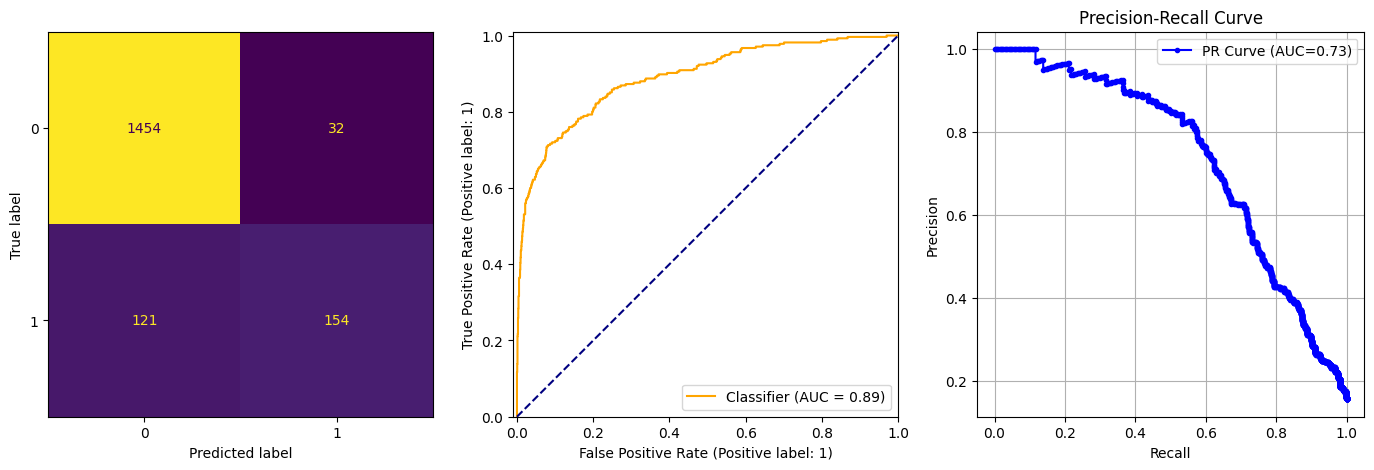

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1486
           1       0.83      0.56      0.67       275

    accuracy                           0.91      1761
   macro avg       0.88      0.77      0.81      1761
weighted avg       0.91      0.91      0.91      1761



In [63]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    ax=axes[0],
    colorbar=False,
)

RocCurveDisplay.from_predictions(
    y_test, y_proba,
    ax=axes[1],
    color='orange',
)
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set_ylim(0, 1.01)
axes[1].set_xlim(-0.01, 1)

axes[2].plot(recall, precision, marker='.', label=f'PR Curve (AUC={pr_auc:.2f})', color='b')
axes[2].set_title('Precision-Recall Curve')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].legend()
axes[2].grid()

plt.show()

print(classification_report(y_test, y_pred))

Вообще, по моему мнение, ROC-AUC в данном проекте неинформативна, потому что имеется сильный дисбаланс классов. Предпочтительнее ориентироватся на PR-кривую, на которой сразу видно работу нашей 'отличной' модели.

1454 (True Negatives - TN): Количество случаев, когда модель правильно предсказала, что клиент не отвалится.

121 (False Positives - FP): Количество случаев, когда модель ошибочно предсказала, что клиент отвалится, а он не отвалился.

32 (False Negatives - FN): Количество случаев, когда модель ошибочно предсказала, что клиент не отвалится, а он отвалился.

154 (True Positives - TP): Количество случаев, когда модель правильно, что клиент отвалится.

## 5. Оценка важности признаков.

Для оценки важности признаков будем использовать SHAP.

In [64]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_train)
expected_value = explainer.expected_value

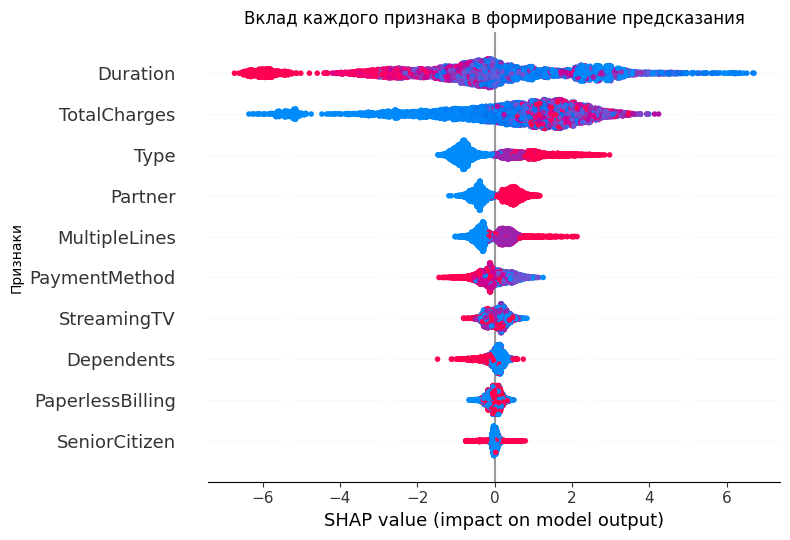

In [65]:
plt.title('Вклад каждого признака в формирование предсказания');
plt.ylabel('Признаки');
shap.summary_plot(
    shap_values=shap_values,
    features=X_train,
    color_bar=False,
)
plt.show();

Исходя из увиденного, наибольший вклад в предсказание модели вносят признаки 'Duration','Type','TotalCharges'.

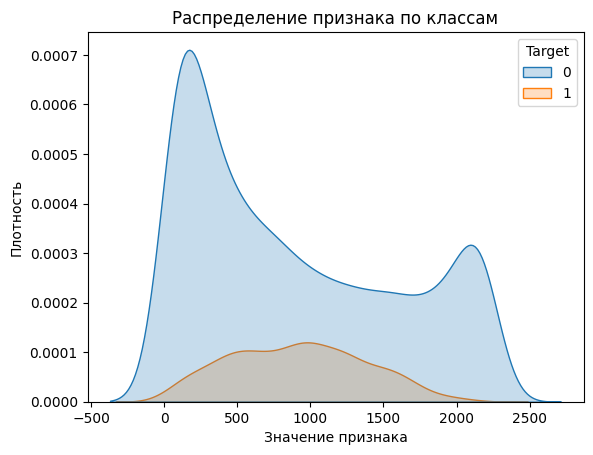

In [68]:
sns.kdeplot(data=df_train, x='Duration', hue='Target', fill=True)
plt.title("Распределение признака по классам")
plt.xlabel("Значение признака")
plt.ylabel("Плотность")
plt.show()

## 5. Итоговый вывод.

В ходе данного исследования был составлен и обработан датасет из четырёх исходных таблиц.

Далее, в ходе EDA был удален ряд сильно скореллированных между собой признаков.

На этапе подбора модели был реализован oversampling, а так же проверены и оптимизированы  три модели : LGBM, RandomForest, и полносвязная сеть прямого распостранения.
Лучшей по целевой метркие ROC-AUC оказалась LGBM.

На тесте она выдала итоговый ROC-AUC 0.89, что полностью удовлетворяет условиям данного проекта. Да PR-кривая после oversampling-а стала куда приятнее.

Так же по результатам SHAPE - тестирования были выявлены четыре основных признака, оказавшие существенное влияние на итоговые результаты классификаци: 'Duration','Type','TotalCharges'.
на SHAPE-е  отлично видно сигнальную комбинацию: чем 'старше' договор и больше месячных трат - тем выше вероятность отвала клиента.

Основываясь на это информации , можно порекомендовать оператору проводить различные акции, связанные с ценой для 'старичков'.

На текщий момент recall у целевого класса - 0.56 при точности 0.83. Для увеличиния recall необходимо регулировать trashhold.